<a href="https://colab.research.google.com/github/karrivinay54/Tuberculosis/blob/main/1st_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install Kaggle (if in a new session)
!pip install kaggle

# 2. Upload your kaggle.json file
# This will open a file upload prompt in your notebook
from google.colab import files
print("Please upload your 'kaggle.json' file:")
files.upload()

# 3. Move the file to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Now, try downloading the dataset again
print("Downloading the TB dataset...")
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# 5. Unzip the dataset
print("Unzipping the dataset...")
!unzip -q tuberculosis-tb-chest-xray-dataset.zip -d ./tb_data

print("Done! Your data should be in the 'tb_data' folder.")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 98% 651M/663M [00:01<00:00, 284MB/s]
100% 663M/663M [00:01<00:00, 382MB/s]
Unzipping the dataset...
Done! Your data should be in the 'tb_data' folder.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# --- Basic Setup ---
IMAGE_SIZE = (224, 224)  # A standard size for image models.
BATCH_SIZE = 8           # The paper used a batch size of 8
# --- THIS IS THE FIX ---
DATA_DIR = './tb_data/TB_Chest_Radiography_Database'

# --- 1. Augmentation for Training Data ---
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Automatically split data: 70% train, 30% test
)

# --- 2. Augmentation for Validation/Testing Data ---
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # Use the same split to get the other 30%
)

# --- 3. Load Data from Directories ---
# Training Generator (70%)
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For 'Normal' and 'Tuberculosis'
    subset='training'          # Specify this is the training set
)

# Validation Generator (30%)
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'        # Specify this is the validation set
)

# Check the classes
print(f"Classes found: {train_generator.class_indices}")

Found 2940 images belonging to 2 classes.
Found 1260 images belonging to 2 classes.
Classes found: {'Normal': 0, 'Tuberculosis': 1}


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, ReLU
from tensorflow.keras.optimizers import Adam

# --- Define Model Constants ---
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) # (224, 224, 3) for color images
LEARNING_RATE = 0.0001 # Used in the paper [cite: 252]

# --- Build the Model (Based on Fig. 1) ---
model = Sequential()

# Input Layer (implied by input_shape in the first layer)
model.add(tf.keras.Input(shape=INPUT_SHAPE))

# Block 1
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # Using a 0.2 dropout rate as a common starting point

# Block 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# --- Classification Head ---
model.add(Flatten())

# Dense Layer (as shown in Fig. 1 before OSL)
# The paper doesn't specify the size, so 128 is a reasonable choice.
model.add(Dense(128))
model.add(ReLU())

# Final Classification Layer (Our "FCCL" version)
# We have 2 classes: 'Normal' and 'Tuberculosis'
model.add(Dense(2, activation='softmax'))

# --- Compile the Model ---
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# --- Print the Model Summary ---
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,144,194 (50.14 MB)

 Trainable params: 13,144,194 (50.14 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- Define Training Constants ---
EPOCHS = 50

# --- Start Training ---
print("Starting model training...")

# We use 'model.fit()' and pass our two data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

print("Training finished!")

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 85s 207ms/step - accuracy: 0.8611 - loss: 0.3597 - val_accuracy: 0.8710 - val_loss: 0.3464
Epoch 2/50
  1/367 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 1.0000 - loss: 0.0776

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 1.0000 - loss: 0.0776 - val_accuracy: 0.8718 - val_loss: 0.3505
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.9249 - loss: 0.2026 - val_accuracy: 0.8838 - val_loss: 0.3050
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8750 - loss: 0.3090 - val_accuracy: 0.8830 - val_loss: 0.2996
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.9274 - loss: 0.1761 - val_accuracy: 0.8758 - val_loss: 0.2644
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8750 - loss: 0.1226 - val_accuracy: 0.8782 - val_loss: 0.2694
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 70s 190ms/step - accuracy: 0.9370 - loss: 0.1633 - val_accuracy: 0.9204 - val_loss: 0.2379
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 1.0000 - loss: 0.0597 - val_accuracy: 0.9156 - val_loss: 0.2412
Epoch 9/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 83s 225ms/step - accuracy: 0.9408 - loss: 0.1499 - val_acc

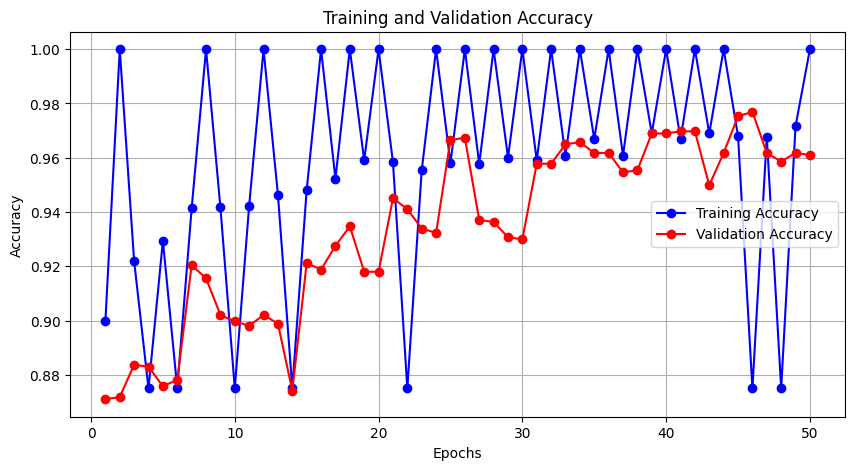

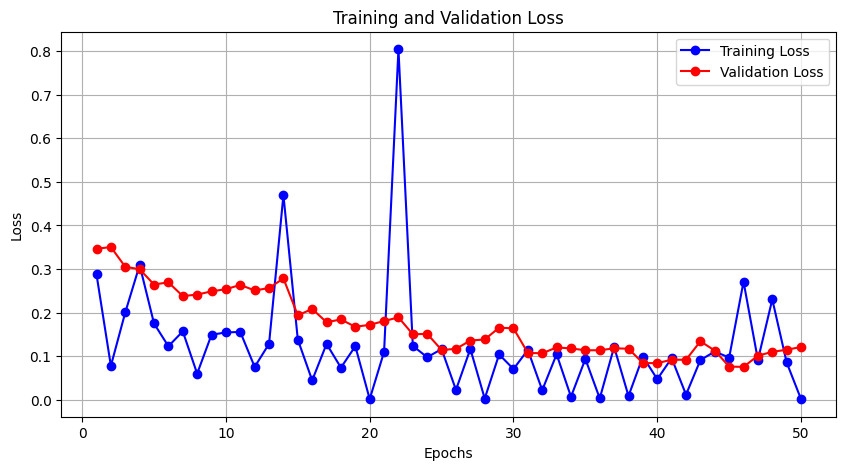

In [6]:
import matplotlib.pyplot as plt

# --- Plot Training & Validation Accuracy ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Training & Validation Loss ---
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
import numpy as np

print("Evaluating the first model (with standard softmax/FCCL) on the 30% validation set...")

# This will run the model on all 1260 validation images
# We use 'validation_generator' as our test set
results = model.evaluate(validation_generator)

print("\n--- Final Model Performance (FCCL) ---")
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.2%}")

Evaluating the first model (with standard softmax/FCCL) on the 30% validation set...
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9538 - loss: 0.1206

--- Final Model Performance (FCCL) ---
Validation Loss: 0.1204
Validation Accuracy: 96.11%


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class OSL(Layer):
    """
    Orthogonal SoftMax Layer (OSL) as described in the paper:
    "An efficient deep learning network with orthogonal softmax layer for
    automatic detection of tuberculosis"
    """
    def __init__(self, units, **kwargs):
        super(OSL, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape is (batch_size, num_features)
        num_features = input_shape[-1]

        # 1. Create the trainable weight matrix W (standard)
        self.W = self.add_weight(
            name='W',
            shape=(num_features, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # 2. Create the trainable bias vector (standard)
        self.b = self.add_weight(
            name='b',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )

        # 3. Create the non-trainable binary mask (the OSL logic)
        # This mask enforces the orthogonal connections.

        # Calculate features per class
        if num_features % self.units != 0:
            raise ValueError(f"Input features ({num_features}) must be divisible by units ({self.units})")
        features_per_class = num_features // self.units

        mask = np.zeros((num_features, self.units))
        for i in range(self.units):
            start = i * features_per_class
            end = (i + 1) * features_per_class
            mask[start:end, i] = 1

        # Convert mask to a non-trainable Keras tensor
        self.B = K.cast(mask, dtype=K.floatx())

        super(OSL, self).build(input_shape)

    def call(self, inputs):
        # This is where the paper's equation is implemented: O = softmax((B*W)I)

        # 1. Apply the binary mask to the weights
        # This zeroes out the non-connected weights
        masked_weights = self.W * self.B  # [cite: 180]

        # 2. Calculate the logits (output before activation)
        logits = K.dot(inputs, masked_weights) + self.b

        # 3. Apply softmax activation
        return tf.nn.softmax(logits)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# --- Model Constants ---
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
LEARNING_RATE = 0.0001
BATCH_SIZE = 8 # Make sure this is defined if you're re-running

# --- Build the OSL Model ---
model_osl = Sequential()
model_osl.add(tf.keras.Input(shape=INPUT_SHAPE))

# Block 1
model_osl.add(Conv2D(128, (3, 3), padding='same'))
model_osl.add(ReLU())
model_osl.add(MaxPooling2D(pool_size=(2, 2)))
model_osl.add(Dropout(0.2))

# Block 2
model_osl.add(Conv2D(128, (3, 3), padding='same'))
model_osl.add(ReLU())
model_osl.add(MaxPooling2D(pool_size=(2, 2)))
model_osl.add(Dropout(0.2))

# Block 3
model_osl.add(Conv2D(128, (3, 3), padding='same'))
model_osl.add(ReLU())
model_osl.add(MaxPooling2D(pool_size=(2, 2)))
model_osl.add(Dropout(0.2))

# --- Classification Head ---
model_osl.add(Flatten())

# Dense Layer (128 features)
model_osl.add(Dense(128))
model_osl.add(ReLU())

# --- HERE IS THE CHANGE ---
# Replace the old layer with our new OSL layer
# We have 2 classes: 'Normal' and 'Tuberculosis'
model_osl.add(OSL(2))
# --- END OF CHANGE ---

# --- Compile the Model ---
optimizer = Adam(learning_rate=LEARNING_RATE)
model_osl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# --- Print the Model Summary ---
model_osl.summary()

# --- Define Callbacks (Still a good idea!) ---
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ osl (OSL)                       │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,144,194 (50.14 MB)

 Trainable params: 13,144,194 (50.14 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# --- Define Training Constants ---
EPOCHS = 50

# --- Start Training the OSL Model ---
print("Starting OSL model training...")

# We use 'model_osl.fit()' and pass our data generators and callbacks
history_osl = model_osl.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]  # Use the callbacks
)

print("OSL model training finished!")

Starting OSL model training...
Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 74s 202ms/step - accuracy: 0.8907 - loss: 0.2998 - val_accuracy: 0.8623 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8750 - loss: 0.1828 - val_accuracy: 0.8639 - val_loss: 0.3351 - learning_rate: 1.0000e-04
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 126s 187ms/step - accuracy: 0.9233 - loss: 0.2131 - val_accuracy: 0.8909 - val_loss: 0.2565 - learning_rate: 1.0000e-04
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7500 - loss: 0.3809 - val_accuracy: 0.8941 - val_loss: 0.2616 - learning_rate: 1.0000e-04
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 68s 186ms/step - accuracy: 0.9110 - loss: 0.2159 - val_accuracy: 0.8997 - val_loss: 0.3055 - learning_rate: 1.0000e-04
Epoch 6/50
  1/367 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.7500 - loss: 0.2828
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
367/367 ━━

In [12]:
import numpy as np

print("Evaluating the new OSL model on the 30% validation set...")

# This will run the model on all 1260 validation images
results_osl = model_osl.evaluate(validation_generator)

print("\n--- Final Model Performance (OSL) ---")
print(f"Validation Loss: {results_osl[0]:.4f}")
print(f"Validation Accuracy: {results_osl[1]:.2%}")

Evaluating the new OSL model on the 30% validation set...
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9060 - loss: 0.2432

--- Final Model Performance (OSL) ---
Validation Loss: 0.2265
Validation Accuracy: 92.06%


Evaluating the first model (FCCL/Softmax)...
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9595 - loss: 0.1231
FCCL Model Final Accuracy: 96.11%

Evaluating the second model (OSL)...
OSL Model Final Accuracy: 92.06%

158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step
Class Names: ['Normal', 'Tuberculosis']

  FCCL (Softmax) Model Report
              precision    recall  f1-score   support

      Normal       0.83      0.87      0.85      1050
Tuberculosis       0.14      0.11      0.12       210

    accuracy                           0.74      1260
   macro avg       0.49      0.49      0.49      1260
weighted avg       0.71      0.74      0.73      1260


      OSL Model Report
              precision    recall  f1-score   support

      Normal       0.83      0.88      0.85      1050
Tuberculosis       0.11      0.07      0.09       210

    accuracy                           0.75      1260
   macro avg       0.47      0.48      0.47   

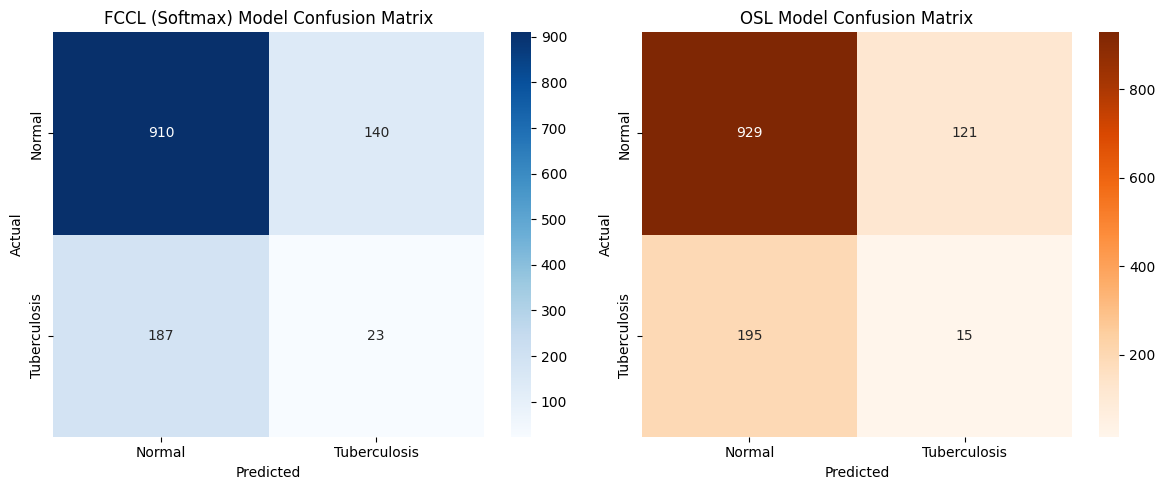

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Get Final Accuracy for the First Model (FCCL) ---
print("Evaluating the first model (FCCL/Softmax)...")
results_fccl = model.evaluate(validation_generator)
print(f"FCCL Model Final Accuracy: {results_fccl[1]:.2%}\n")

print("Evaluating the second model (OSL)...")
print(f"OSL Model Final Accuracy: {results_osl[1]:.2%}\n")


# --- 2. Get True Labels and Predicted Labels ---
# We need to get all the true labels from the generator
# Make sure to set steps to cover the entire validation set
validation_steps = validation_generator.samples // BATCH_SIZE
if validation_generator.samples % BATCH_SIZE != 0:
    validation_steps += 1 # Ensure we get all samples

# Get true labels
y_true = validation_generator.classes

# Get predictions from FCCL model
y_pred_fccl = model.predict(validation_generator, steps=validation_steps)
y_pred_fccl_classes = np.argmax(y_pred_fccl, axis=1)

# Get predictions from OSL model
y_pred_osl = model_osl.predict(validation_generator, steps=validation_steps)
y_pred_osl_classes = np.argmax(y_pred_osl, axis=1)

# Get the class names
target_names = list(validation_generator.class_indices.keys())
print("Class Names:", target_names)


# --- 3. Print Classification Reports ---
print("\n" + "="*30)
print("  FCCL (Softmax) Model Report")
print("="*30)
print(classification_report(y_true, y_pred_fccl_classes, target_names=target_names))

print("\n" + "="*30)
print("      OSL Model Report")
print("="*30)
print(classification_report(y_true, y_pred_osl_classes, target_names=target_names))


# --- 4. Plot Confusion Matrices ---
# Note: The FCCL model had its weights restored by EarlyStopping,
# so 'model' variable holds the best version.

# FCCL Model Confusion Matrix
cm_fccl = confusion_matrix(y_true, y_pred_fccl_classes)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_fccl, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('FCCL (Softmax) Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# OSL Model Confusion Matrix
cm_osl = confusion_matrix(y_true, y_pred_osl_classes)
plt.subplot(1, 2, 2)
sns.heatmap(cm_osl, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('OSL Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

Found 1260 images belonging to 2 classes.
Generating predictions (this may take a moment)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step

  FCCL (Softmax) Model Report [CORRECTED]
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98      1050
Tuberculosis       0.99      0.77      0.87       210

    accuracy                           0.96      1260
   macro avg       0.98      0.89      0.92      1260
weighted avg       0.96      0.96      0.96      1260


      OSL Model Report [CORRECTED]
              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95      1050
Tuberculosis       0.90      0.59      0.71       210

    accuracy                           0.92      1260
   macro avg       0.91      0.79      0.83      1260
weighted avg       0.92      0.92      0.91      1260



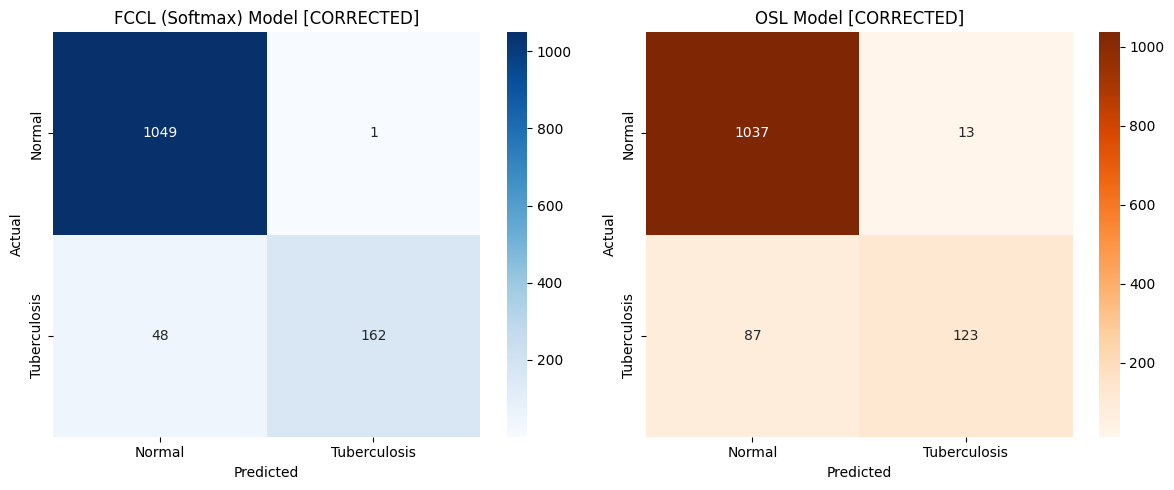

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. RE-CREATE THE VALIDATION GENERATOR (NO SHUFFLE) ---
# This is the crucial fix!
validation_datagen_fixed = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # Use the same split to get the other 30%
)

validation_generator_fixed = validation_datagen_fixed.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # <-- THE FIX
)

# --- 2. Get True Labels and Predicted Labels ---
print("Generating predictions (this may take a moment)...")

# Get true labels (now in a stable order)
y_true = validation_generator_fixed.classes

# Get predictions from FCCL model (now in the same stable order)
y_pred_fccl = model.predict(validation_generator_fixed)
y_pred_fccl_classes = np.argmax(y_pred_fccl, axis=1)

# Get predictions from OSL model (now in the same stable order)
y_pred_osl = model_osl.predict(validation_generator_fixed)
y_pred_osl_classes = np.argmax(y_pred_osl, axis=1)

# Get the class names
target_names = list(validation_generator_fixed.class_indices.keys())


# --- 3. Print Classification Reports (These will be correct now) ---
print("\n" + "="*30)
print("  FCCL (Softmax) Model Report [CORRECTED]")
print("="*30)
print(classification_report(y_true, y_pred_fccl_classes, target_names=target_names))

print("\n" + "="*30)
print("      OSL Model Report [CORRECTED]")
print("="*30)
print(classification_report(y_true, y_pred_osl_classes, target_names=target_names))


# --- 4. Plot Confusion Matrices (These will be correct now) ---
# FCCL Model Confusion Matrix
cm_fccl = confusion_matrix(y_true, y_pred_fccl_classes)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_fccl, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('FCCL (Softmax) Model [CORRECTED]')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# OSL Model Confusion Matrix
cm_osl = confusion_matrix(y_true, y_pred_osl_classes)
plt.subplot(1, 2, 2)
sns.heatmap(cm_osl, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('OSL Model [CORRECTED]')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()